# Problem Outline

Consider a dataset (`ground_control_points.csv`, measured in eastings and northings) representing a set of ground control points. The coordinates of these points have also been measured using satellite imaging (`coordinates.csv`, as `x` and `y` coordinates).  

A suitable model for transforming the data from the imaged coordinates into the ground coordinates is to be derived, and the best estimates of the corresponding parameters are to be determined.

Candidate models are the **similarity** and **affine** transformations, the equations for which are given below.

## Forming The Matrices ##
### Similarity ###
The similarity matrix, $A_{sim}$, is designed using the following equations:
\begin{equation}
f_i(a, b, \Delta{x})=ax_i - by_i + \Delta{x}
\end{equation}
\begin{equation}
f_i(a, b, \Delta{y})=bx_i + ay_i + \Delta{y}
\end{equation}

Thus, our [design matrix](https://www.statlect.com/glossary/design-matrix#:~:text=A%20design%20matrix%20is%20a,each%20column%20to%20a%20characteristic.) requires four parameters: $E, N, x, y$. This results in a matrix with the following shape:

\begin{bmatrix}
E_1& -N_1& 1& 0\\\
\vdots& \vdots& \vdots& \vdots\\\
E_n& -N_n& 1& 0\\\
N_1& E_1&  0& 1\\\
\vdots& \vdots& \vdots& \vdots\\\
N_n& E_n& 0& 1
\end{bmatrix}

### Affine ###
The affine matrix, $A_{aff}$, is designed using the following equations:

\begin{equation}
f_i(a_0, a_1, a_2) = a_0 + a_1x_i + a_2y_i \\\
\end{equation}
\begin{equation}
f_i(b_0, b_1, b_2) = b_0 + b_1x_i + b_2y_i \\\
\end{equation}

This results in a matrix with the following shape:

\begin{bmatrix}
1& E_1& N_1& 0& 0& 0 \\\
\vdots& \vdots& \vdots& \vdots& \vdots& \vdots\\\
1& E_n& N_n& 0& 0& 0 \\\
0& 0& 0& 1& E_1& N_1 \\\
\vdots& \vdots& \vdots& \vdots& \vdots& \vdots\\\
0& 0& 0& 1& E_n& N_n
\end{bmatrix}

The $b$ vector is identical for both transforms, and is formed of all the $x$ components of the observations, followed by all the $y$ components of the observations.  
The covariance matrix $C_b$ is usually diagonal, but in this case `statsmodels` requires a vector, of identical dimensions to $b$. It is formed of the square of the standard deviation of the $x$ values, for all $x$, followed by the square of the standard deviation of the $y$ values, for all $y$. Statsmodels requires it in the form of $1/C_b$.  It is converted into a diagonal weight matrix, **W**, in order to obtain the quality $(\sigma)$ of the transformations.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels
import statsmodels.formula.api as sm
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Only execute the cell below if you have $\LaTeX$ and the appropriate fonts installed.

In [ ]:
from matplotlib import rc
# import matplotlib as mpl
# mpl.rcParams['figure.dpi'] = 300
rc('font', **{'family':'sans-serif',
    'sans-serif':['Helvetica'],
    'monospace': ['Inconsolata'],
    'serif': ['Helvetica']})
rc('text', **{'usetex': True})
rc('text', **{'latex.preamble': '\\usepackage{sfmath}'})

In [ ]:
# imaged observations
coords = pd.read_csv('../data/coordinates.csv', index_col=0)
# ground control points
ground_control_points = pd.read_csv('../data/ground_control_points.csv')

#### Since the design matrices are formed of the easting and northing measurements and various arrangements of one and zero columns, it's easiest to create them by forming dicts which are given as input to the Pandas DataFrame constructor. In order to keep the functions flexible, they are not applied to DataFrames, but take iterables such as lists, tuples or numpy arrays as input

In [ ]:
def affine_dict(points):
    """
    Return a dict with the correct parameter arrangement for the affine design matrix
    Takes an iterable of x, y point tuples as input 
    """
    zeros = np.zeros(len(points))
    ones = np.ones(len(points))
    return {
        'a1x': np.concatenate(([point[0] for point in points], zeros)),
        'a2y': np.concatenate(([point[1] for point in points], zeros)),
        'b1x': np.concatenate((zeros, [point[0] for point in points])),
        'b2y': np.concatenate((zeros, [point[1] for point in points])),
        'a': np.concatenate((ones, zeros)),
        'b': np.concatenate((zeros, ones))
    }

def similarity_dict(points):
    """
    Return a dict with the correct parameter arrangement for the similarity design matrix
    Takes an iterable of x, y point tuples as input
    """
    zeros = np.zeros(len(points))
    ones = np.ones(len(points))
    return {
        'a': np.concatenate(([point[0] for point in points], [point[1] for point in points])),
        'b': np.concatenate((np.array([point[1] for point in points]) * -1, [point[0] for point in points])),
        'Delta_x': np.concatenate((ones, zeros)),
        'Delta_y': np.concatenate((zeros, ones))
    }

Alternatively, we could form our design matrices manually, by appending DataFrames:
```python
    dflen = len(ground_control_points)
    zeros = np.zeros(dflen)
    ones = np.ones(dflen)

    # affine transform A matrix
    affine_A = pd.DataFrame({
        'a': ones,
        'a1x': ground_control_points['E'],
        'a2y': ground_control_points['N'],
        'b': zeros,
        'b1x': zeros,
        'b2y': zeros,
    }).append(pd.DataFrame({
        'a': zeros,
        'a1x': zeros,
        'a2y': zeros,
        'b': ones,
        'b1x': ground_control_points['E'],
        'b2y': ground_control_points['N'],
        }), ignore_index=True
    )
    
    # similarity transform A matrix
    similarity_A = pd.DataFrame({
        'a': ground_control_points['E'],
        'b': ground_control_points['N'] * -1,
        'Delta_x': ones,
        'Delta_y': zeros,
    }).append(pd.DataFrame({
        'a': ground_control_points['N'],
        'b': ground_control_points['E'],
        'Delta_x': zeros,
        'Delta_y': ones,
        }), ignore_index=True
    )
```

## Form Design Matrices

In [ ]:
affine_A = pd.DataFrame(
    affine_dict(ground_control_points.values)
    )

similarity_A = pd.DataFrame(
    similarity_dict(ground_control_points.values)
    )

affine_A.head()

,a1x,a2y,b1x,b2y,a,b
0,501840.7579,185681.5922,0.0,0.0,1.0,0.0
1,502808.3026,186667.6431,0.0,0.0,1.0,0.0
2,502509.0600,186961.7100,0.0,0.0,1.0,0.0
3,502543.4900,185883.5300,0.0,0.0,1.0,0.0
4,502564.6500,186577.9900,0.0,0.0,1.0,0.0


## Form b Vector

In [ ]:
b_vector = pd.DataFrame({
    'coordinates': pd.concat([
        coords['x_coordinates'],
        coords['y_coordinates']],
        ignore_index=True)
    })

b_vector.head()

,coordinates
0,-0.149588
1,0.117489
2,0.071546
3,0.012923
4,0.059942


## Join design matrix and b vector into single DataFrames, for easier manipulation

In [ ]:
affine_A = affine_A.join(b_vector)
similarity_A = similarity_A.join(b_vector)

## Create a covariance vector

In [ ]:
# we can safely divide by 2, because we're guaranteed an equal number of x and y coords
half = int(len(b_vector) / 2)
covariance = pd.Series(
    [b_vector['coordinates'][:half].std() ** 2] * half +
    [b_vector['coordinates'][half:].std() ** 2] * half
)
print(covariance.head())
print(covariance.tail())

0    0.007911
1    0.007911
2    0.007911
3    0.007911
4    0.007911
dtype: float64
103    0.00751
104    0.00751
105    0.00751
106    0.00751
107    0.00751
dtype: float64


## Carry out the regressions

In [ ]:
affine_results = sm.wls(
    formula='coordinates ~ a + a1x + a2y + b + b1x + b2y',
    data=affine_A,
    weights=1 / covariance).fit()
affine_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:            coordinates   R-squared:                       1.000
Model:                            WLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 9.316e+05
Date:                Mon, 25 Mar 2024   Prob (F-statistic):          6.51e-236
Time:                        10:06:07   Log-Likelihood:                 689.65
No. Observations:                 108   AIC:                            -1367.
Df Residuals:                     102   BIC:                            -1351.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -43.4359      0.037  -1176.088      0.000     -43.509     -43.363
a            -75.2691      0.059  -1279.011      0.000     -75.386     -75.152
a1x            0.0002   1.64e-07   1306.384      0.000       0.000       0.000
a2y          6.12e-05   1.52e-07    402.923      0.000    6.09e-05    6.15e-05
b             31.8332      0.058    549.436      0.000      31.718      31.948
b1x        -6.055e-05   1.59e-07   -380.059      0.000   -6.09e-05   -6.02e-05
b2y            0.0002   1.48e-07   1522.644      0.000       0.000       0.000
==============================================================================
Omnibus:                      132.905   Durbin-Watson:                   2.064
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2298.174
Skew:                          -4.513   Prob(JB):                         0.00
Kurtosis:                      23.718   Cond. No.                     4.03e+21
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.27e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [ ]:
similarity_results = sm.wls(
    formula='coordinates ~ a + b + Delta_x + Delta_y',
    data=similarity_A,
    weights=1 / covariance).fit()
similarity_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:            coordinates   R-squared:                       0.999
Model:                            WLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 5.503e+04
Date:                Mon, 25 Mar 2024   Prob (F-statistic):          2.91e-166
Time:                        10:06:11   Log-Likelihood:                 508.28
No. Observations:                 108   AIC:                            -1009.
Df Residuals:                     104   BIC:                            -997.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -44.2930      0.141   -313.207      0.000     -44.573     -44.013
a              0.0002   5.61e-07    392.234      0.000       0.000       0.000
b          -5.932e-05   5.62e-07   -105.497      0.000   -6.04e-05   -5.82e-05
Delta_x      -77.3361      0.225   -343.520      0.000     -77.783     -76.890
Delta_y       33.0430      0.225    147.046      0.000      32.597      33.489
==============================================================================
Omnibus:                        3.832   Durbin-Watson:                   2.442
Prob(Omnibus):                  0.147   Jarque-Bera (JB):                2.145
Skew:                          -0.016   Prob(JB):                        0.342
Kurtosis:                       2.310   Cond. No.                     5.56e+21
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 6.67e-29. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## Out-of-band Prediction

In [ ]:
def random_point(df):
    """ return a random point from the uniform distribution using min & max from the df """
    x = np.random.uniform(
        df['E'].min(), df['E'].max())
    y = np.random.uniform(
        df['N'].min(), df['N'].max())
    return x, y

In [ ]:
# get 10 random points
rpoints = [random_point(ground_control_points) for x in range(10)]

In [ ]:
# predict transformed coordinates
predicted_affine = list(affine_results.predict(exog=affine_dict(rpoints)))
predicted_similarity = list(similarity_results.predict(exog=similarity_dict(rpoints)))

## Plot results

<Figure size 640x480 with 0 Axes>

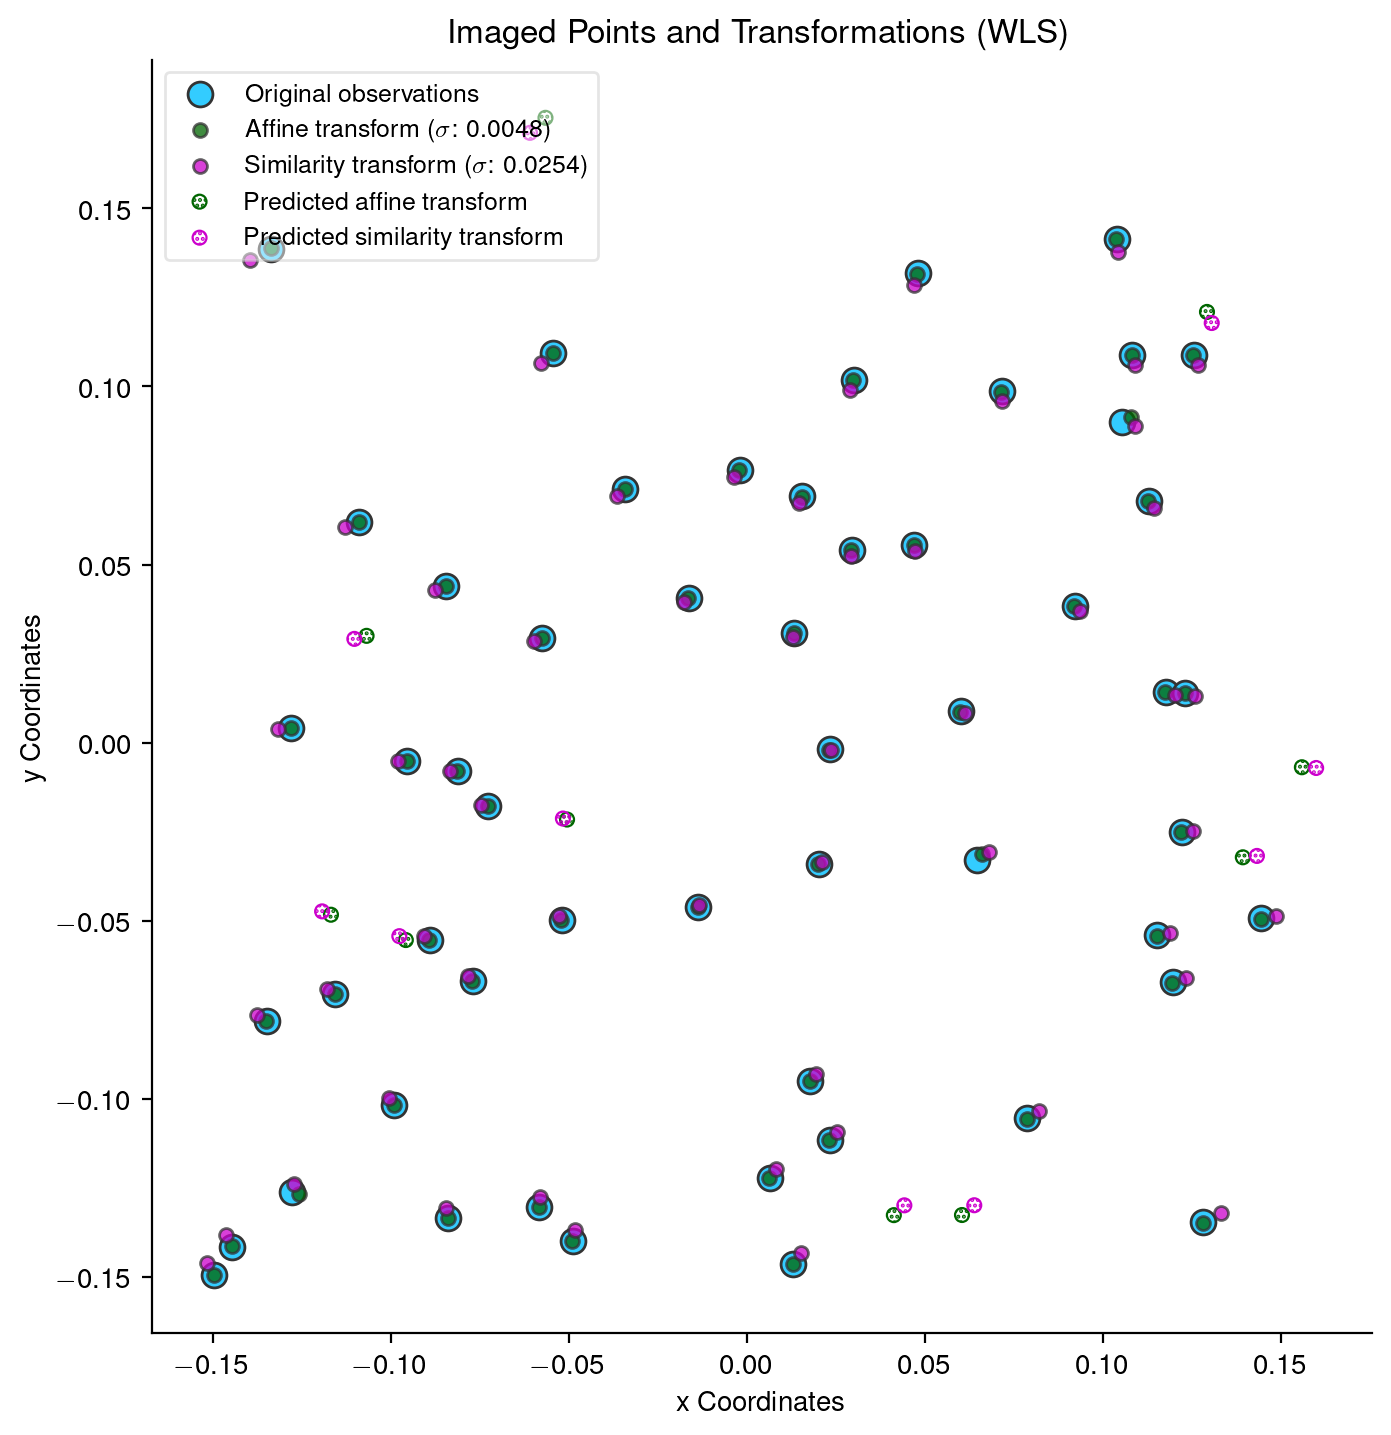

In [ ]:
plt.clf()
fig = plt.figure(figsize=(7.28, 7.28))
ax = fig.add_subplot(111, aspect='equal', facecolor='none')
orig = plt.scatter(
    coords['x_coordinates'],
    coords['y_coordinates'],
    color='#33CCFF',
    edgecolor='#333333',
    marker='o',
    lw=1,
    s=80,
    alpha=1.0)
# the predict() method generates points used to plot updated observations
aff = plt.scatter(
    affine_results.predict()[:half],
    affine_results.predict()[half:],
    marker='o',
    color='#006600',
    edgecolor='#333333',
    lw=1,
    s=25,
    alpha=0.75)
sim = plt.scatter(
    similarity_results.predict()[:half],
    similarity_results.predict()[half:],
    marker='o',
    color='#CC00CC',
    edgecolor='#333333',
    lw=1,
    s=25,
    alpha=0.75)

pred_aff = plt.scatter(
    predicted_affine[:len(rpoints)],
    predicted_affine[len(rpoints):],
    lw=.8,
    s=25,
    color='none',
    edgecolor='#006600',
    hatch='......',
    alpha=1.)

pred_sim = plt.scatter(
    predicted_similarity[:len(rpoints)],
    predicted_similarity[len(rpoints):],
    lw=.8,
    s=25,
    color='none',
    edgecolor='#CC00CC',
    hatch='......',
    alpha=1.) 

ax.set_xlabel('x Coordinates')
ax.set_ylabel('y Coordinates')
plt.title("Imaged Points and Transformations (WLS)")
leg = plt.legend(
    (orig, aff, sim, pred_aff, pred_sim),
    ('Original observations',
    r'Affine transform ($\sigma$: %0.4f)' % np.sqrt(affine_results.mse_resid),
    r'Similarity transform ($\sigma$: %0.4f)' % np.sqrt(similarity_results.scale),
    r'Predicted affine transform',
    r'Predicted similarity transform'),
    loc='upper left',
    scatterpoints=1,
    fontsize=9)
leg.get_frame().set_alpha(0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.tight_layout()
ax.grid(False)
plt.savefig('../WLS.png', format="png", bbox_inches='tight', transparent=True, dpi=300)

## Conclusion

It's clear from the sigma-nought values and by visual inspection of the plot above that the affine transform is the more accurate model.

# Manually Calculate Out-of-band Values

Using statsmodels to predict out-of-band values is useful, but in certain cases we may wish to calculate them 'manually'; that is, by using a transformation matrix to transform given eastings and northings. The parameters returned by our `fit()` method allow us to accomplish this, once we've arranged our input points in the correct shape.

The transformation matrix for the affine transform is as follows:

\begin{align}
\begin{bmatrix}
    x'& \dots& x'_{n}\\\
    y'& \dots& y'_{n}\\\
    1& \dots& 1_{n}
\end{bmatrix}
=
\begin{bmatrix}
    a1x& a2y& a&\\\
    b1x& b2y& b&\\\
    0& 0& 1
\end{bmatrix}
\begin{bmatrix}
    x& \dots& x_{n}\\\
    y& \dots& y_{n}\\\
    1& \dots& 1_{n}
\end{bmatrix}
\end{align}

([Goshtasby, A.A., 2012. Image Registration: Principles, Tools and Methods. p348]((https://books.google.co.uk/books?id=VthiwQOT6t4C&pg=PA347&lpg=PA347&dq=affine+transform+a+a1x+a2y&source=bl&ots=8WOI4xglcn&sig=iQ3VpSD7xzJ6XIa7ZWhgFm-Izto&hl=en&sa=X&ei=oseOVKbsJofD7gaC6IDgDQ&ved=0CD4Q6AEwBg#v=onepage&q=affine%20transform%20a%20a1x%20a2y&f=false)))


To which we add the intercept we've calculated.

In [ ]:
def affine_oob(params, points):
    """
    Calculate out-of-band points using least-squares params
    inputs:
        Array of estimated params (intercept, a, a1x a2y, b, b1x, b2y)
        List or array of point tuples
    returns list of affine-transformed point tuples
    """
    p = params.params
    # form affine matrix
    tmatrix = np.vstack([
        np.array([p.iloc[2], p.iloc[3], p.iloc[1]]),
        np.array([p.iloc[5], p.iloc[6], p.iloc[4]]),
        np.array([0, 0, 1])
    ])
    # form param matrix
    orig = np.vstack([(point[0], point[1], 1) for point in points]).T
    dot_result = np.dot(tmatrix, orig)
    # add intercept
    with_intercept = [dot_result[0] + p.iloc[0], dot_result[1] + p.iloc[0]]
    return list(zip(with_intercept[0], with_intercept[1]))

In [ ]:
# second result from statsmodels prediction
predicted_affine[1], predicted_affine[11] 

(0.041208349635269315, -0.1326337462002625)

In [ ]:
res = affine_oob(affine_results, rpoints)
# second manually-calculated point
res[1]

(0.041208349635255104, -0.1326337462002698)